# First attempts at supervised classification for flares

I am using only the data that were in visual_data.fits, which had a cutoff at CON_NSIGMA > 5. Flares are defined as having the FLARE variable = 'Y' (FLARE='-' were treated as no flare). Only the 499 second observations are included. I exported the data csv files and cross-matched on extras-ID.

I split the data into train-test randomly, stratified. I run a two-class supervised classification. I evaluate the performance using the f1 score, the accuracy, and by looking at pecision-recall curve.

I compare the performance of two models: [XGBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) (gradient boosted trees) and a naive cutoff of the p-value of fitting with a flare model.

Finally, I use some explainability techniques on the uninterpretable XGBoost model to explain its decisions a posteriori. 

In [3]:
import numpy as np
import pandas as pd
from astropy.io import fits
from imodels import FIGSClassifier, FIGSRegressor, get_clean_dataset, FIGSClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier as xgb
import seaborn as sns

### Reading in the data

In [5]:
visual_data = pd.read_csv("visual_data.csv")

In [6]:
visual_data.shape

(13855, 10)

In [7]:
complete_data = pd.read_csv("complete_data_499.csv")

In [8]:
cdf = pd.read_csv("cdf_499.csv")

In [9]:
cdf['EXTRAS_ID'] = np.array([str(s)[2:-1] for s in cdf['EXTRAS_ID']])

In [10]:
cdf.head()

Unnamed: 0         OBS_ID  SRC_NUM  BIN_SIZE     F_VAR  F_VAR_ERR  \
0           2  b'0000110101'        1       499  0.692592   0.165601   
1           6  b'0000110101'        2       499  0.997198   0.264032   
2          10  b'0000110101'        3       499  0.788664   0.615132   
3          14  b'0000110101'        4       499  1.926109   1.752167   
4          18  b'0000110101'        5       499  1.662160   0.516661   

            AVE       AVE_ERR         STDEV          SKEW  ...      FLUX_P40  \
0  1.350140e-13  1.527083e-14  1.891364e-13 -1.577253e-39  ...  1.025936e-13   
1  3.009117e-14  8.882952e-15  9.760700e-14 -2.143861e-40  ...  2.122912e-14   
2  2.041009e-14  6.064366e-15  6.238247e-14  1.746324e-40  ...  4.900570e-15   
3 -9.831734e-15  6.184388e-15  5.308298e-14 -9.130072e-41  ... -2.952255e-14   
4 -4.676036e-15  4.837585e-15  4.365292e-14  1.337472e-40  ... -9.115572e-15   

       FLUX_P50      FLUX_P60    FLUX_P67.5      FLUX_P75    FLUX_P82.5  \
0  1.669971e-13  2.281533e-13  2.736146e-13  3.228643e-13  3.818557e-13   
1  5.609994e-14  9.367392e-14  1.234087e-13  1.561170e-13  1.963942e-13   
2  3.078012e-14  5.932018e-14  8.181361e-14  1.069676e-13  1.374425e-13   
3 -9.982597e-15  1.049904e-14  2.792021e-14  4.863727e-14  7.406276e-14   
4  5.942725e-15  2.325977e-14  3.944744e-14  6.052905e-14  9.064565e-14   

       FLUX_P90      FLUX_P95      FLUX_P99           EXTRAS_ID  
0  4.668250e-13  5.680305e-13  7.785595e-13  0000110101_001_499  
1  2.550528e-13  3.274976e-13  5.067174e-13  0000110101_002_499  
2  1.812201e-13  2.337048e-13  3.657630e-13  0000110101_003_499  
3  1.103176e-13  1.536351e-13  2.680498e-13  0000110101_004_499  
4  1.358205e-13  1.877717e-13  3.699771e-13  0000110101_005_499  

[5 rows x 55 columns]

In [138]:
(complete_data["F_PROB_FLCON"] == -1000).sum()

247

### Cross matching on EXTRAS_ID and prepping

This was a bit of a pain using the whole complete_data because it would run out of memory on my laptop, but it works now by restricting to complete_data_499 only.

In [11]:
data_visual_complete = pd.merge(visual_data, complete_data, how='inner', on = 'EXTRAS_ID')
data = pd.merge(data_visual_complete, cdf, how='inner', on = 'EXTRAS_ID')

Let us see the names of all the columns in the combined dataframe

In [46]:
retain = np.zeros(len(data.columns), dtype=bool)
retain_nomodels = np.copy(retain)
for i, c in zip(range(len(data.columns)), data.columns):
    if (i > 23) and (i < 145):
        if not (c.endswith('TS') or c.endswith('NHP') or c.startswith('F_NSIGMA')):
            retain[i] = True
            retain_nomodels[i] = True
            if ('DIP' in c) or ('EC' in c) or ('FL' in c):
                retain_nomodels[i] = False
    print(i, c)

retain[179:224] = True
retain[143] = False
retain_nomodels[179:224] = True
retain_nomodels[143] = False
print(retain)
print(retain_nomodels)

#DIP1, DIP, EC1, EC, FL

0 Unnamed: 0_x
1 OBS_ID_x
2 SRC_NUM_x
3 DIPECLPER
4 MULTIDEP
5 FLARE
6 MULTIFL
7 FIT
8 GOOD_FIT
9 EXTRAS_ID
10 Unnamed: 0_y
11 3XMM
12 4XMM
13 PPS
14 OBS_ID_y
15 SRC_NUM_y
16 BIN_SIZE_x
17 PRED_CTS_INREG
18 PN_RAWCTS
19 M1_RAWCTS
20 M2_RAWCTS
21 TSTART_LC
22 TSTOP_LC
23 N_BINS
24 AVERAGE
25 AVERAGE_ERR
26 ST_DEV
27 MEDIAN_x
28 MED_ABS_DEV_x
29 CON_TS
30 CON_NHP
31 CON_NSIGMA
32 CON_CON
33 CON_CON_ERR
34 LIN_TS
35 LIN_NHP
36 LIN_NSIGMA
37 LIN_CON
38 LIN_CON_ERR
39 LIN_LIN
40 LIN_LIN_ERR
41 QU_TS
42 QU_NHP
43 QU_NSIGMA
44 QU_CON
45 QU_CON_ERR
46 QU_LIN
47 QU_LIN_ERR
48 QU_QU
49 QU_QU_ERR
50 EXP_TS
51 EXP_NHP
52 EXP_NSIGMA
53 EXP_CON
54 EXP_CON_ERR
55 EXP_NOR
56 EXP_NOR_ERR
57 EXP_EXP
58 EXP_EXP_ERR
59 DIP1_TS
60 DIP1_NHP
61 DIP1_NSIGMA
62 DIP1_TMIN
63 DIP1_TMIN_ERR
64 DIP1_DT
65 DIP1_DT_ERR
66 DIP1_FLMIN
67 DIP1_FLMIN_ERR
68 DIP1_FLMAX
69 DIP1_FLMAX_ERR
70 DIP_TS
71 DIP_NHP
72 DIP_NSIGMA
73 DIP_TMIN
74 DIP_TMIN_ERR
75 DIP_DT
76 DIP_DT_ERR
77 DIP_FLMIN
78 DIP_FLMIN_ERR
79 DIP_FLMAX
80 DIP

Preparing the final dataset for train-test splitting. I am turning 'FLARE' into a binary variable and selecting only certain columns (from 24 to 144, see to what this corresponds in terms of variable names by looking above). I then split the dataset into train-test. The split is stratified given how unbalanced the data set is.

(array([7568., 2907., 1199.,  539.,  305.,  197.,  120.,  101.,   82.,
         837.]),
 array([ 5.0000467 ,  6.93280573,  8.86556476, 10.79832379, 12.73108282,
        14.66384185, 16.59660088, 18.52935991, 20.46211894, 22.39487797,
        24.327637  ]),
 <BarContainer object of 10 artists>)

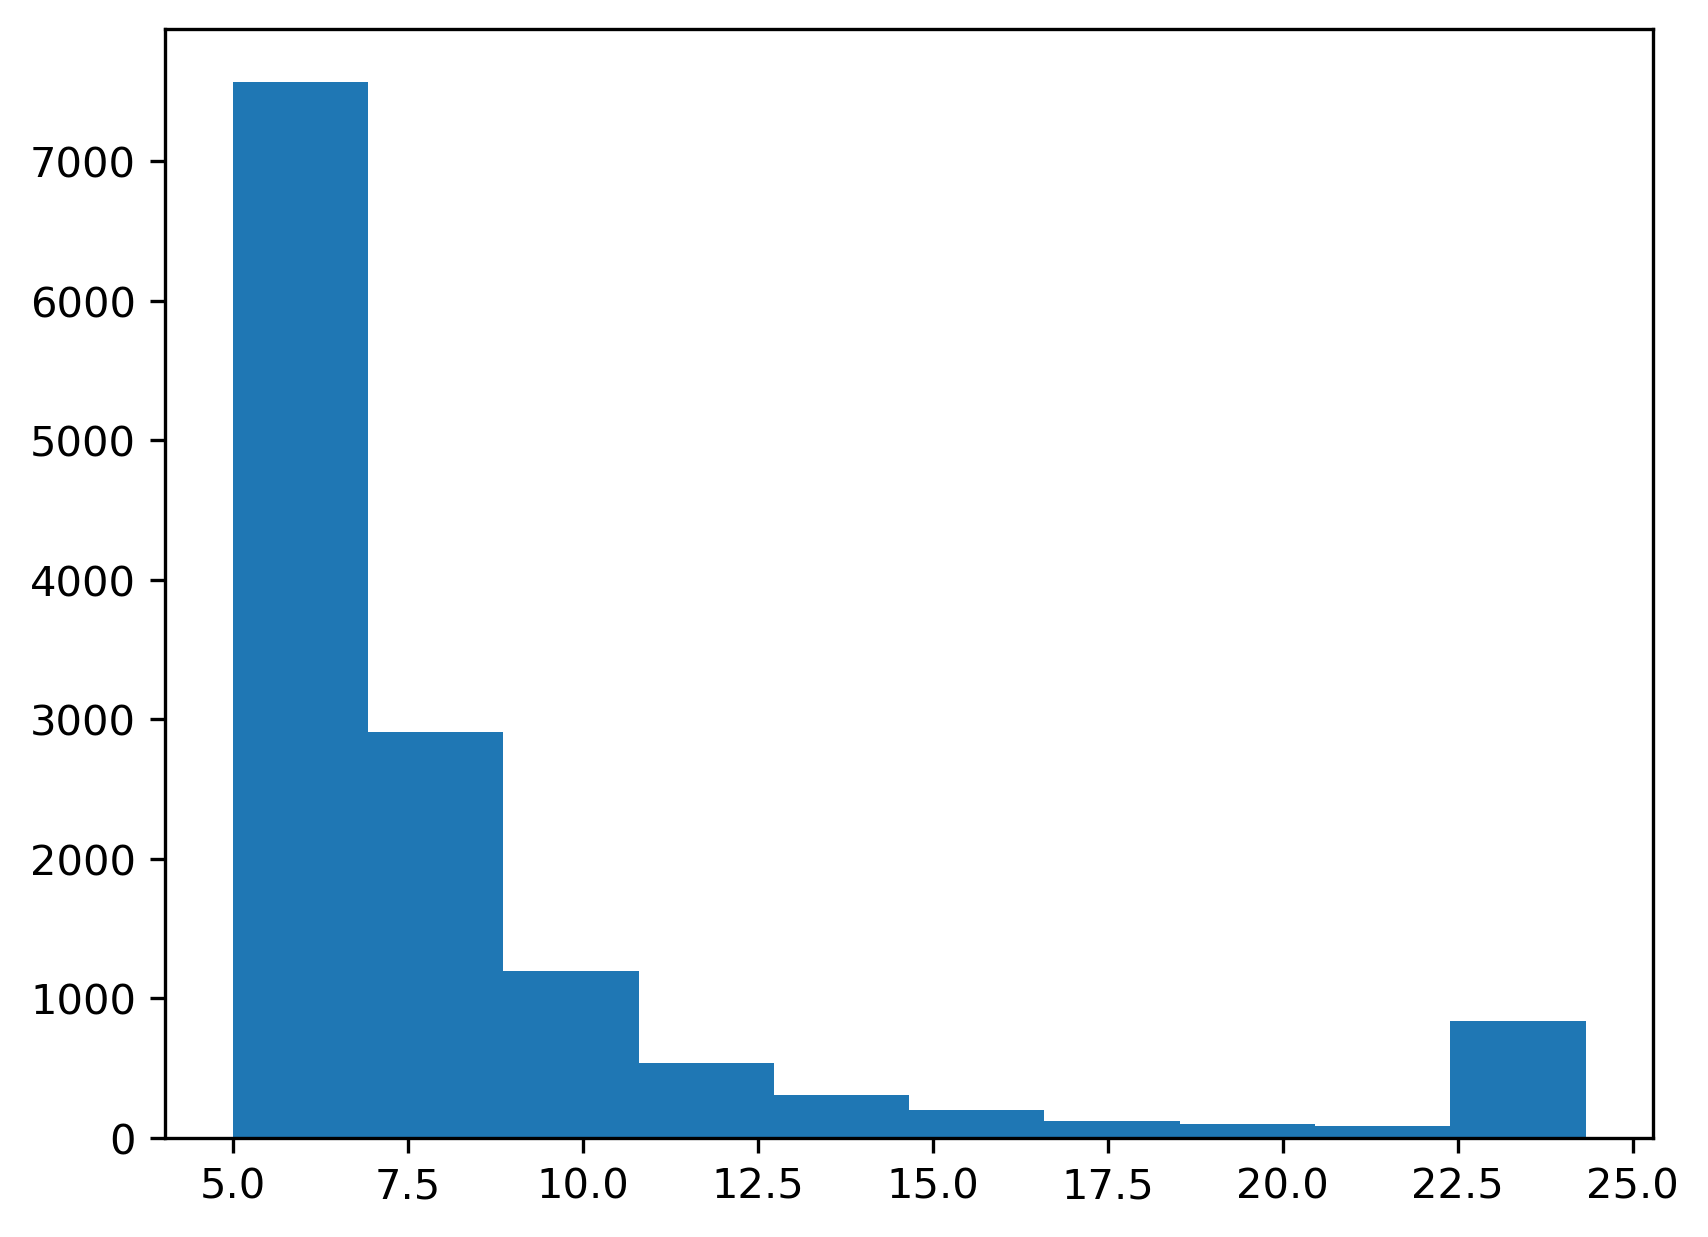

In [142]:
plt.hist(data["CON_NSIGMA"])

In [48]:
select_nomodel = retain_nomodels[retain]
y = data.copy()['FLARE']
y[y == '-'] = 'N'
y = (y=='Y')
X = data.copy().iloc[:,retain]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)
X_train_nomodel, X_test_nomodel, y_train_nomodel, y_test_nomodel = X_train.iloc[:,select_nomodel], X_test.iloc[:,select_nomodel], y_train, y_test

In [49]:
X_train_nomodel.columns

Index(['AVERAGE', 'AVERAGE_ERR', 'ST_DEV', 'MEDIAN_x', 'MED_ABS_DEV_x',
       'CON_NSIGMA', 'CON_CON', 'CON_CON_ERR', 'LIN_NSIGMA', 'LIN_CON',
       'LIN_CON_ERR', 'LIN_LIN', 'LIN_LIN_ERR', 'QU_NSIGMA', 'QU_CON',
       'QU_CON_ERR', 'QU_LIN', 'QU_LIN_ERR', 'QU_QU', 'QU_QU_ERR',
       'EXP_NSIGMA', 'EXP_CON', 'EXP_CON_ERR', 'EXP_NOR', 'EXP_NOR_ERR',
       'EXP_EXP', 'EXP_EXP_ERR', 'F_PROB_LINCON', 'F_PROB_QUCON',
       'F_PROB_QULIN', 'F_PROB_EXPCON', 'BB_MAXBLOCKS', 'BB_MB_MINTIME',
       'SKEW', 'KURT', 'RELVAR', 'AMPLIT', 'MEDIAN_y', 'MED_ABS_DEV_y',
       'MEDMAXOFF', 'TFRAC_BEL1E', 'TFRAC_ABO1E', 'TFRAC_BEL3E', 'TFRAC_ABO3E',
       'TFRAC_BEL5E', 'TFRAC_ABO5E', 'TFRAC_MID20', 'TFRAC_BEL1S',
       'TFRAC_ABO1S', 'TFRAC_BEL3S', 'TFRAC_ABO3S', 'TFRAC_BEL5S',
       'TFRAC_ABO5S', 'TFRAC_BEL1MAD', 'TFRAC_ABO1MAD', 'TFRAC_BEL3MAD',
       'TFRAC_ABO3MAD', 'TFRAC_BEL5MAD', 'TFRAC_ABO5MAD', 'FIT_AVE',
       'FIT_AVE_ERR', 'FIT_SIGMA', 'FIT_SIGMA_ERR', 'FLUX_P01', 'FLUX_P05',
  

#### Comparing the training data frame with model-dependent quantites to the one without
It looks like I am losing 136-78 features. Whoa.

In [147]:
for c in X_train.columns:
    print(c)

AVERAGE
AVERAGE_ERR
ST_DEV
MEDIAN_x
MED_ABS_DEV_x
CON_NSIGMA
CON_CON
CON_CON_ERR
LIN_NSIGMA
LIN_CON
LIN_CON_ERR
LIN_LIN
LIN_LIN_ERR
QU_NSIGMA
QU_CON
QU_CON_ERR
QU_LIN
QU_LIN_ERR
QU_QU
QU_QU_ERR
EXP_NSIGMA
EXP_CON
EXP_CON_ERR
EXP_NOR
EXP_NOR_ERR
EXP_EXP
EXP_EXP_ERR
DIP1_NSIGMA
DIP1_TMIN
DIP1_TMIN_ERR
DIP1_DT
DIP1_DT_ERR
DIP1_FLMIN
DIP1_FLMIN_ERR
DIP1_FLMAX
DIP1_FLMAX_ERR
DIP_NSIGMA
DIP_TMIN
DIP_TMIN_ERR
DIP_DT
DIP_DT_ERR
DIP_FLMIN
DIP_FLMIN_ERR
DIP_FLMAX
DIP_FLMAX_ERR
DIP_PER
DIP_PER_ERR
EC1_NSIGMA
EC1_TIN
EC1_TIN_ERR
EC1_TFIN
EC1_TFIN_ERR
EC1_FLMIN
EC1_FLMIN_ERR
EC1_FLMAX
EC1_FLMAX_ERR
EC_NSIGMA
EC_T1
EC_T1_ERR
EC_T2
EC_T2_ERR
EC_FL1
EC_FL1_ERR
EC_FL2
EC_FL2_ERR
EC_PER
EC_PER_ERR
FL_NSIGMA
FL_CON
FL_CON_ERR
FL_DFL
FL_DFL_ERR
FL_TMAX
FL_TMAX_ERR
FL_DT
FL_DT_ERR
FL_RT
FL_RT_ERR
F_PROB_LINCON
F_PROB_QUCON
F_PROB_QULIN
F_PROB_EXPCON
F_PROB_DIP1CON
F_PROB_DIPCON
F_PROB_DIP1DIP
F_PROB_EC1CON
F_PROB_ECCON
F_PROB_EC1EC
F_PROB_FLCON
BB_MAXBLOCKS
BB_MB_MINTIME
SKEW
KURT
RELVAR
AMPLIT
MEDIAN_y
ME

In [51]:
X_train_nomodel.shape

(11084, 78)

### Training XGBoost, a black box model

Now let us fit an XGBoost model to the training data and evaluate its predictions on the test data. Note that I am not optimizing the model's hyperparameters.

In [86]:
model_xgb = xgb(n_estimators=1000, random_state=888)
model_xgb_nomodel = xgb(n_estimators=1000, random_state=888)  

model_xgb.fit(X_train, y_train)  
preds_xgb = model_xgb.predict(X_test)

model_xgb_nomodel.fit(X_train_nomodel, y_train_nomodel)  
preds_xgb_nomodel = model_xgb_nomodel.predict(X_test_nomodel)

In [87]:
from sklearn.metrics import precision_recall_curve as prc
preds_proba_xgb = model_xgb.predict_proba(X_test)
precision_recall_xgboost = prc(y_test, preds_proba_xgb[:,1])

preds_proba_xgb_nomodel = model_xgb_nomodel.predict_proba(X_test_nomodel)
precision_recall_xgboost_nomodel = prc(y_test_nomodel, preds_proba_xgb_nomodel[:,1])

In [88]:
accuracy_xgb = accuracy_score(y_test, preds_xgb)
accuracy_xgb

0.9682425117286179

In [89]:
accuracy_xgb_nomodel = accuracy_score(y_test_nomodel, preds_xgb_nomodel)
accuracy_xgb_nomodel

0.954168170335619

The accuracy score is deceivingly high. The dataset is very unbalanced, so predicting always no flare would yield an accuracy of:

In [90]:
sum(1-y_test)/len(y_test)

0.9231324431613136

Clearly we need a better metric for evaluating the classifier. Here is the raw confusion matrix:

In [91]:
confusion_matrix(y_test, preds_xgb)

array([[2521,   37],
       [  51,  162]])

In [92]:
confusion_matrix(y_test_nomodel, preds_xgb_nomodel)

array([[2516,   42],
       [  85,  128]])

In [93]:
from sklearn.metrics import precision_recall_curve

The precision score (aka purity in astro catalogs) measures what fraction of actual flares was found among the sources tagged as flares. It is pretty decent:

In [94]:
precision_xgb = precision_score(y_test, preds_xgb)
precision_xgb

0.8140703517587939

In [95]:
precision_xgb_nomodel = precision_score(y_test_nomodel, preds_xgb_nomodel)
precision_xgb_nomodel

0.7529411764705882

On the other hand the recall score (completeness for astronomers I guess) is not so good:

In [96]:
recall_xgb = recall_score(y_test, preds_xgb)
recall_xgb

0.7605633802816901

In [97]:
recall_xgb_nomodel = recall_score(y_test_nomodel, preds_xgb_nomodel)
recall_xgb_nomodel

0.6009389671361502

The recall score is the fraction of actual flares we correctly tag as flares. We miss one in four.

The F1 score summarizes both recall and precision by taking their harmonic mean. Here it is:

In [98]:
f1_xgb = f1_score(y_test, preds_xgb)
f1_xgb

0.7864077669902911

In [99]:
f1_xgb_nomodel = f1_score(y_test_nomodel, preds_xgb_nomodel)
f1_xgb_nomodel

0.6684073107049608

### Post-hoc explainability on XGBoost

In [100]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model_xgb, X_test, y_test, n_repeats=10, random_state=888)

In [101]:
r_nomodel = permutation_importance(model_xgb_nomodel, X_test_nomodel, y_test_nomodel, n_repeats=10, random_state=888)

In [102]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 3*r.importances_std[i] > 0: #stuff that is useful at the three-sigma level
         print(f"{X_train.columns[i]:<8} "
               f"{r.importances_mean[i]:.3f} "
               f" +/- {r.importances_std[i]:.3f}")

F_PROB_FLCON 0.041  +/- 0.003
FL_DT_ERR 0.014  +/- 0.002
FL_NSIGMA 0.011  +/- 0.001
MEDMAXOFF 0.005  +/- 0.001
BB_MB_MINTIME 0.003  +/- 0.001
BB_MAXBLOCKS 0.003  +/- 0.001
FL_TMAX_ERR 0.003  +/- 0.000
FL_RT_ERR 0.003  +/- 0.001
FL_TMAX  0.003  +/- 0.001
DIP_PER  0.002  +/- 0.000
DIP_TMIN 0.001  +/- 0.000
EC_T2    0.001  +/- 0.000


In [103]:
for i in r_nomodel.importances_mean.argsort()[::-1]:
    if r_nomodel.importances_mean[i] - 3*r_nomodel.importances_std[i] > 0:
         print(f"{X_train_nomodel.columns[i]:<8} "
               f"{r_nomodel.importances_mean[i]:.3f} "
               f" +/- {r_nomodel.importances_std[i]:.3f}")

TFRAC_ABO5E 0.098  +/- 0.003
TFRAC_ABO3E 0.079  +/- 0.003
MEDMAXOFF 0.013  +/- 0.002
BB_MAXBLOCKS 0.009  +/- 0.001
TFRAC_ABO3S 0.009  +/- 0.002
TFRAC_BEL5MAD 0.007  +/- 0.002
TFRAC_BEL3MAD 0.007  +/- 0.001
LIN_NSIGMA 0.004  +/- 0.001
TFRAC_ABO1E 0.004  +/- 0.001
TFRAC_ABO5S 0.004  +/- 0.001


### Comparison with naïve cutoff on flare model p-value

/opt/anaconda3/envs/extras/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


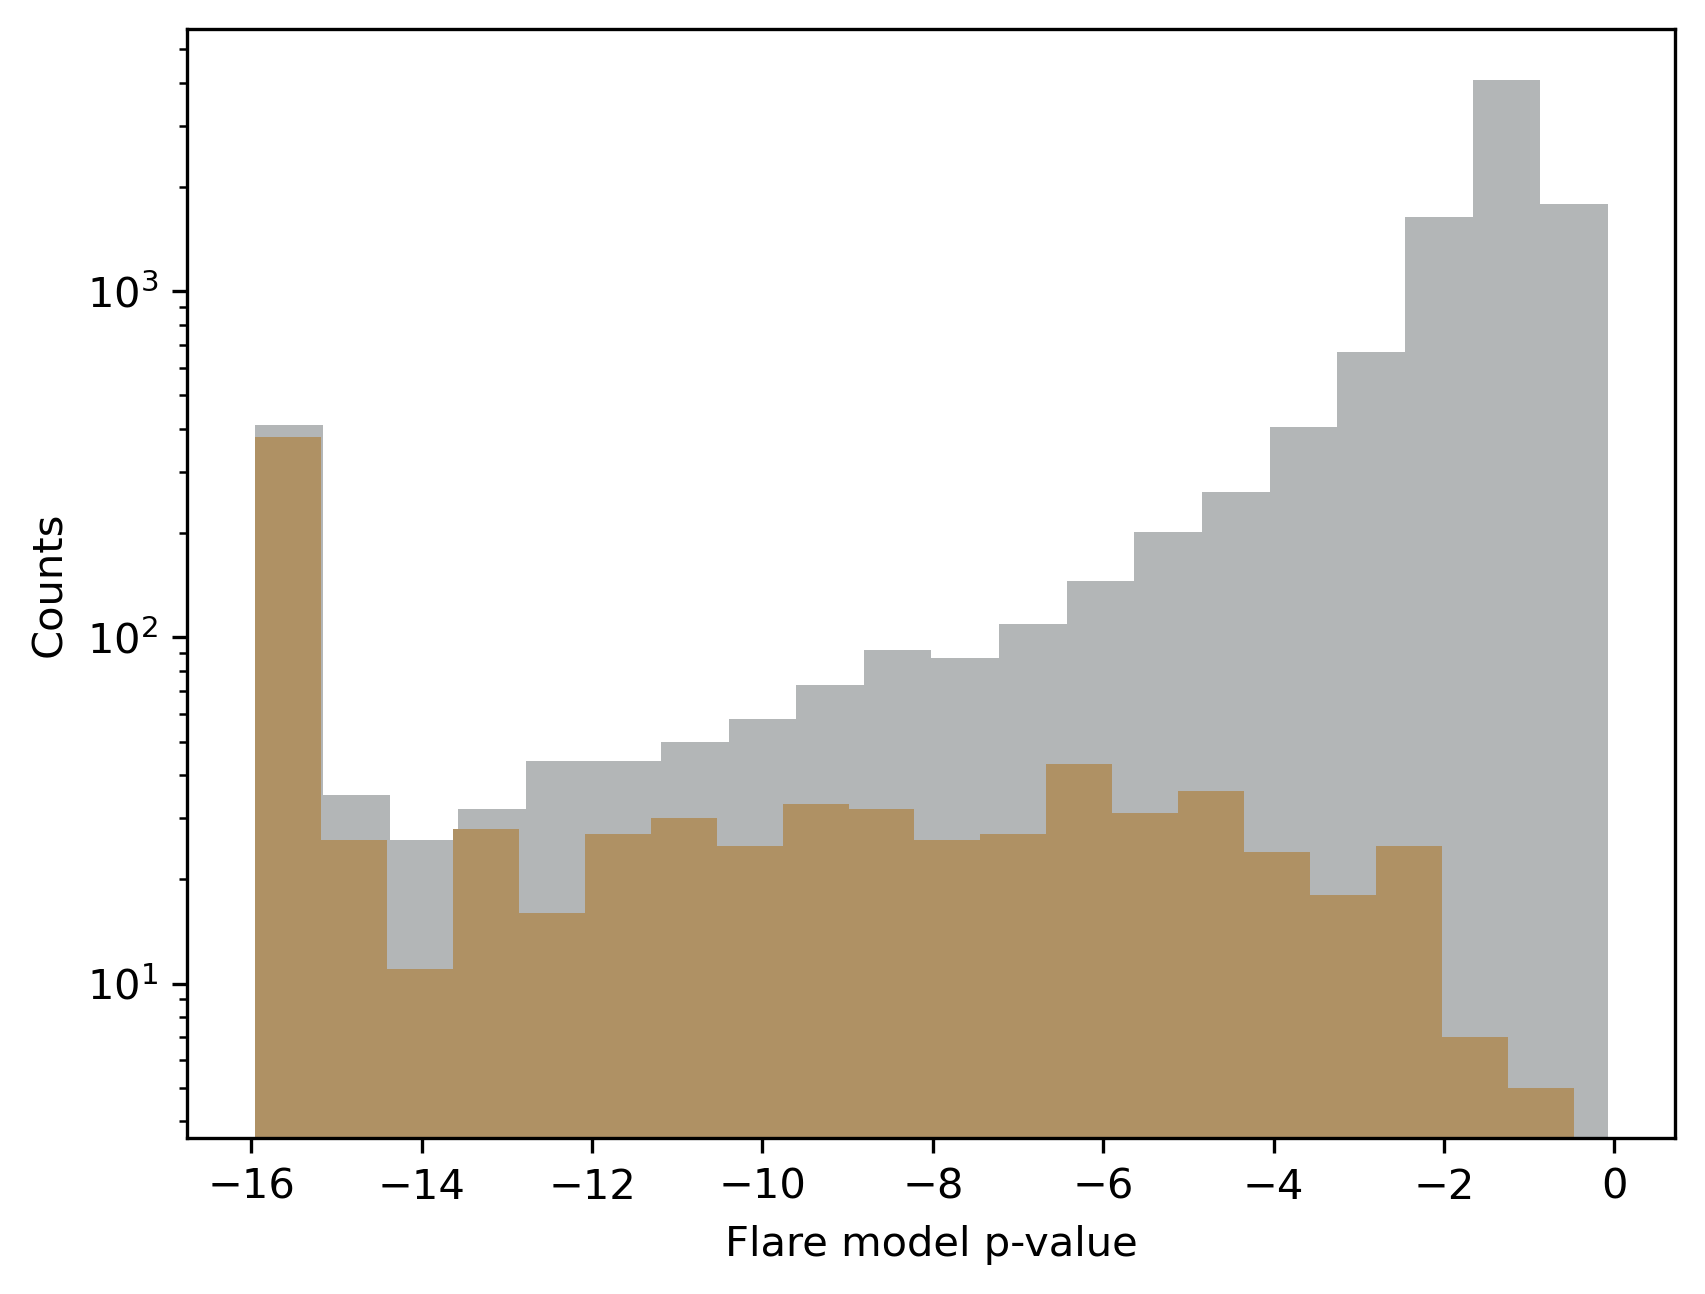

In [104]:
plt.hist(np.log10(X_train['F_PROB_FLCON'][~y_train]), color = "#B3B6B7", bins = 20)
plt.hist(np.log10(X_train['F_PROB_FLCON'][y_train]), color = "#AF9164", bins = 20)
plt.xlabel("Flare model p-value")
plt.ylabel("Counts")
plt.yscale('log')
plt.show()

In [105]:
cutoff = -5 #'five sigma cutoff'
fn = (np.log10(X_test['F_PROB_FLCON'][y_test]) > cutoff).sum()
tn = (np.log10(X_test['F_PROB_FLCON'][~y_test]) > cutoff).sum()
tp = (np.log10(X_test['F_PROB_FLCON'][y_test]) <= cutoff).sum()
fp = (np.log10(X_test['F_PROB_FLCON'][~y_test]) <= cutoff).sum()

precision_simple_cutoff = tp/(fp+tp)
recall_simple_cutoff = tp/(fn+tp)
f1_simple_cutoff = 2.0/((1/precision_simple_cutoff) + (1/recall_simple_cutoff))
accuracy_simple_cutoff = (tp+tn)/(fp+fn+tp+tn)

print(accuracy_xgb, precision_xgb, recall_xgb, f1_xgb)
print(accuracy_simple_cutoff, precision_simple_cutoff, recall_simple_cutoff, f1_simple_cutoff)
print(accuracy_xgb_nomodel, precision_xgb_nomodel, recall_xgb_nomodel, f1_xgb_nomodel)


0.9682425117286179 0.8140703517587939 0.7605633802816901 0.7864077669902911
0.8675090252707581 0.3530534351145038 0.8685446009389671 0.5020352781546812
0.954168170335619 0.7529411764705882 0.6009389671361502 0.6684073107049608


/var/folders/8w/66mbmptd4ws3j45r5hp0c6w80000gn/T/ipykernel_5941/3952505379.py:7: RuntimeWarning: invalid value encountered in scalar divide
  precision_simple_cutoff = tp/(fp+tp)


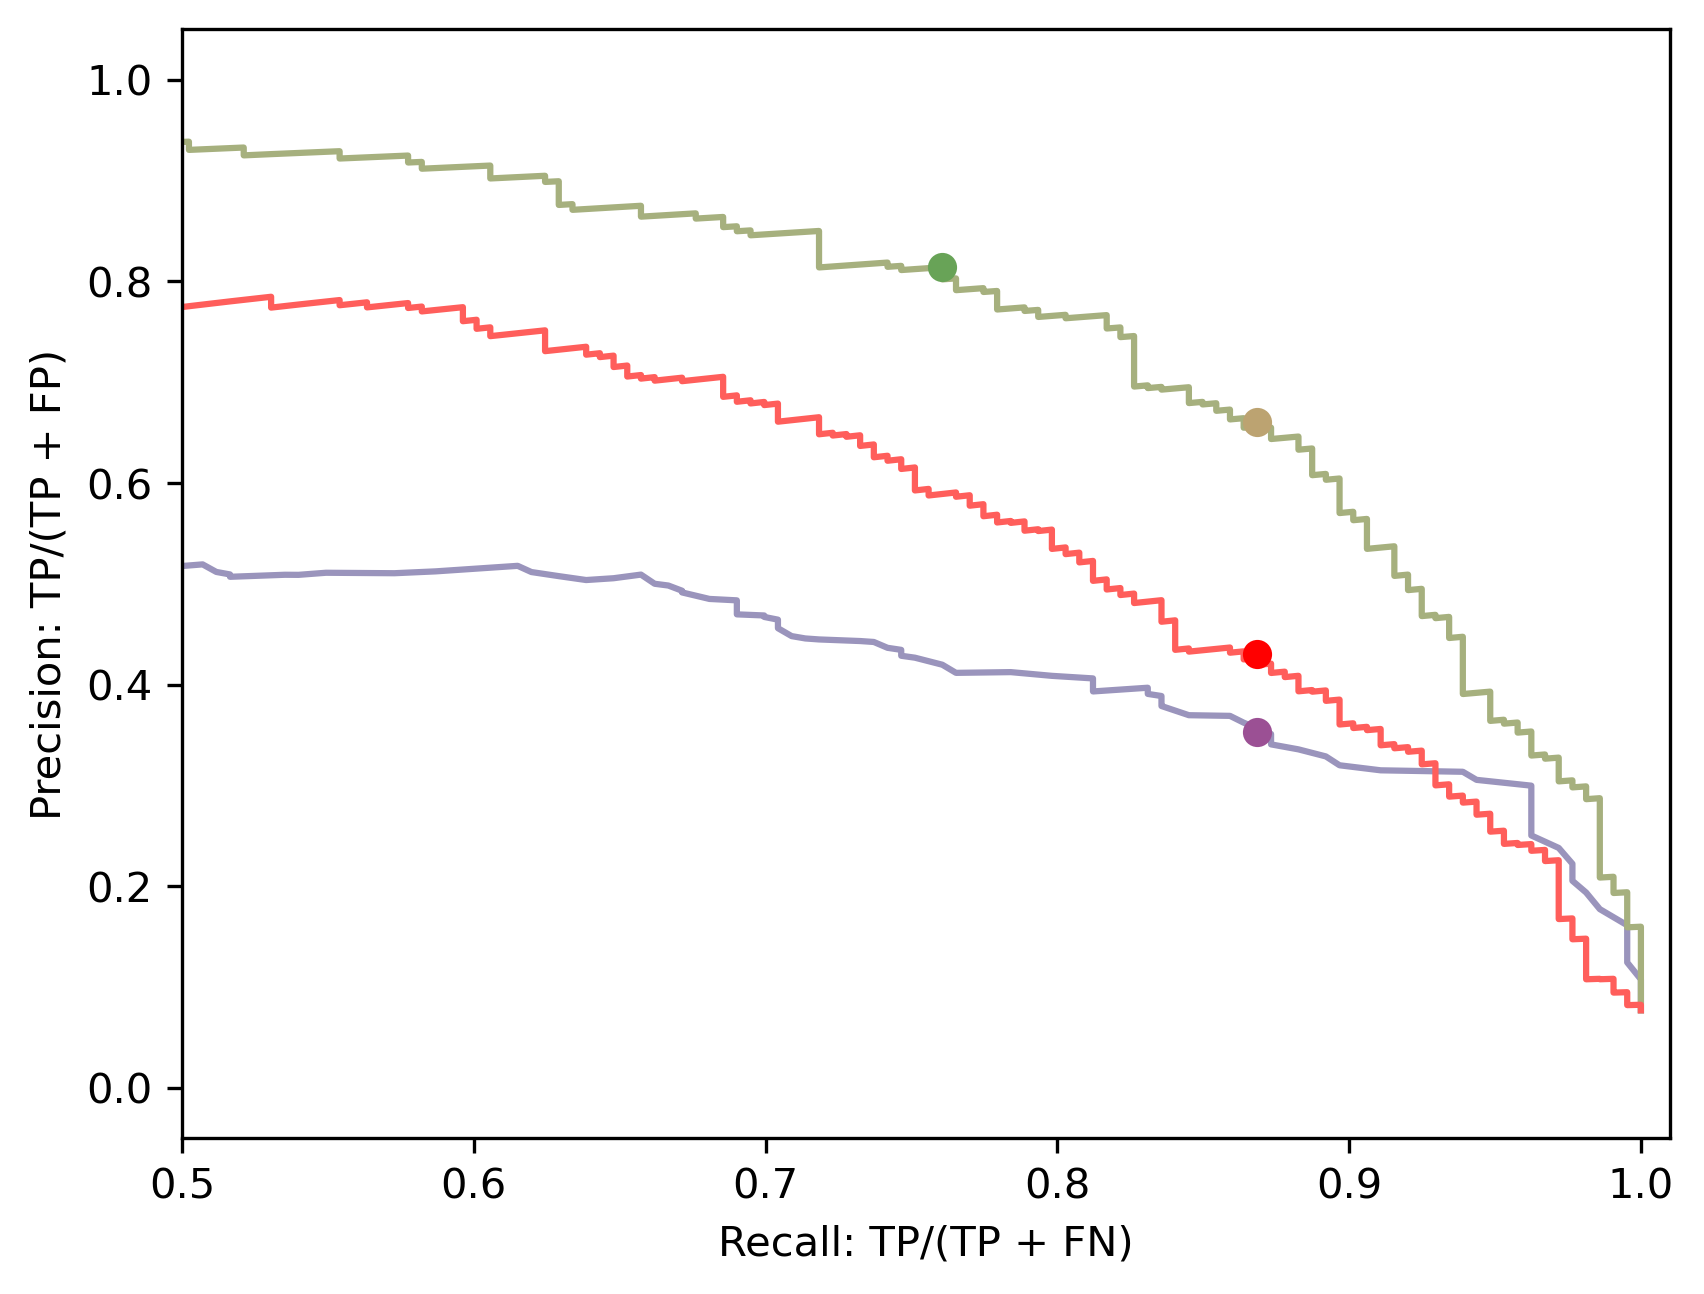

In [110]:
def prec_rec_naive(cutoff):
    fn = (np.log10(X_test['F_PROB_FLCON'][y_test]) > cutoff).sum()
    tn = (np.log10(X_test['F_PROB_FLCON'][~y_test]) > cutoff).sum()
    tp = (np.log10(X_test['F_PROB_FLCON'][y_test]) <= cutoff).sum()
    fp = (np.log10(X_test['F_PROB_FLCON'][~y_test]) <= cutoff).sum()

    precision_simple_cutoff = tp/(fp+tp)
    recall_simple_cutoff = tp/(fn+tp)
    #f1_simple_cutoff = 2.0/((1/precision_simple_cutoff) + (1/recall_simple_cutoff))
    #accuracy_simple_cutoff = (tp+tn)/(fp+fn+tp+tn)
    return precision_simple_cutoff, recall_simple_cutoff

a = np.array([prec_rec_naive(c) for c in -np.linspace(0, 18, 100)])
plt.scatter(recall_simple_cutoff, precision_simple_cutoff, color = "#9B5094",zorder=13)
plt.scatter(recall_xgb, precision_xgb, color = "#68A357", zorder=13)
plt.scatter(recall_simple_cutoff, 0.66, color = "#BCA371", zorder=13)
plt.plot(a[:,1], a[:,0], color = "#9A94BC")
plt.plot(precision_recall_xgboost[1], precision_recall_xgboost[0], color = "#A6B07E")
plt.plot(precision_recall_xgboost_nomodel[1], precision_recall_xgboost_nomodel[0], color = "#FF5E5B")
plt.scatter(recall_simple_cutoff, 0.43, color = "#FF0000", zorder=13)
plt.xlim([0.5,1.01])
plt.xlabel("Recall: TP/(TP + FN)")
plt.ylabel("Precision: TP/(TP + FP)")
plt.show()

The purple curve corresponds to setting a cutoff on F_PROB_FLCON, with the brighter purple dot corresponding to a 5 sigma cutoff. The green curve corresponds to XGBoost, with the brighter green dot corresponding to the cutoff chosen automatically by scikit-learn. The brown dot on the XGBoost curve corresponds to the level of precision that XGBoost would reach at the recall reached by the five-sigma cutoff on F_PROB_FLCON. The corresponding precision is $0.66$ compared to $0.35$ for the five-sigma cutoff on F_PROB_FLCON. This implies that the number of sources I have to vet manually would be about half ($0.35/0.66$) if I used XGBoost instead of the cutoff, as discussed below. This is a fair comparison because the number of flares I would lose (false negatives) would be the same for both classifiers.

#### Additionally, the red curve corresponds to an XGBoost classifier trained without model dependent quantities. At the recall obtained by enforcing a 5-sigma cutoff on F_PROB_FLCON it has a slightly higher precision. At lower recalls it obtains a higher precision (tending towards that of XGBoost with all features) and at higher recall it drops below the simple cutoff strategy in precision.

### What does this mean in terms of manual work saved?

In the following TP will stand for true positives, actual flares correctly tagged as flares; TN will stand for true negatives, actual non-flares correctly tagged as non-flares; FP will stand for false negatives, actual flares tagged as non-flares; and FP will stand for false positives, non-flares tagged as flares.


Out of $N$ sources there are $p N$ actual flares, where $p$ is the actual prevalence of flares.

Given a model with recall $r$, it will correctly tag as flares $r p N$ sources: remember that recall is

\begin{equation}
r = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}
\end{equation}

I will also tag as flares an additional $s (1-p) N$ sources, where $s$ is the false positive rate

\begin{equation}
s = \frac{\mathrm{FP}}{\mathrm{FP} + \mathrm{TN}} = \frac{r p (1/P - 1)}{1-p}
\end{equation}

where $P$ is precision,

\begin{equation}
P = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}}
\end{equation}

So in total I will have to look at
\begin{equation}
(r p + s (1-p)) N = \frac{rp}{P} N
\end{equation}
sources out of at total of $N$, to catch $r p N$ actual flares.

I can now compare two models with precision $P$ and $P^\prime > P$ in terms of how many more sources I will have to look at when using the worse model with respect to the better model.

With the model that has precision $P$, to catch $M$ flares I will need to look at $M/P$ sources; with the model that has precision $P^\prime$ I will need to look at $M/P^\prime$ sources.

#### Doubling the precision will halve the number of sources I have to look at to catch the same number of real flares


In [111]:
p = sum(y_train)/len(y_train)

print("Prevalence: " + str(np.round(p, 2)))

print("Precision (simple cutoff): " + str(np.round(precision_simple_cutoff,2)))

print("Precision (XGBoost without model dependent features): 0.43")
      
print("Precision (XGBoost at the same recall as the simple cutoff): 0.66")

print("To catch 100 flares, without classifier, I have to look at: " + str(100.0/p) + " sources")
print("To catch 100 flares, with cutoff on F_PROB_FLCON, I have to look at: " + str(np.round(100.0/precision_simple_cutoff)) + " sources")
print("To catch 100 flares, with XGBoost without model dependent features, I have to look at: " + str(np.round(100.0/0.43)) + " sources")
print("To catch 100 flares, with XGBoost, I have to look at: " + str(np.round(100.0/0.66)) + " sources")

Prevalence: 0.08
Precision (simple cutoff): 0.35
Precision (XGBoost without model dependent features): 0.43
Precision (XGBoost at the same recall as the simple cutoff): 0.66
To catch 100 flares, without classifier, I have to look at: 1304.0 sources
To catch 100 flares, with cutoff on F_PROB_FLCON, I have to look at: 283.0 sources
To catch 100 flares, with XGBoost without model dependent features, I have to look at: 233.0 sources
To catch 100 flares, with XGBoost, I have to look at: 152.0 sources


## Further visualization

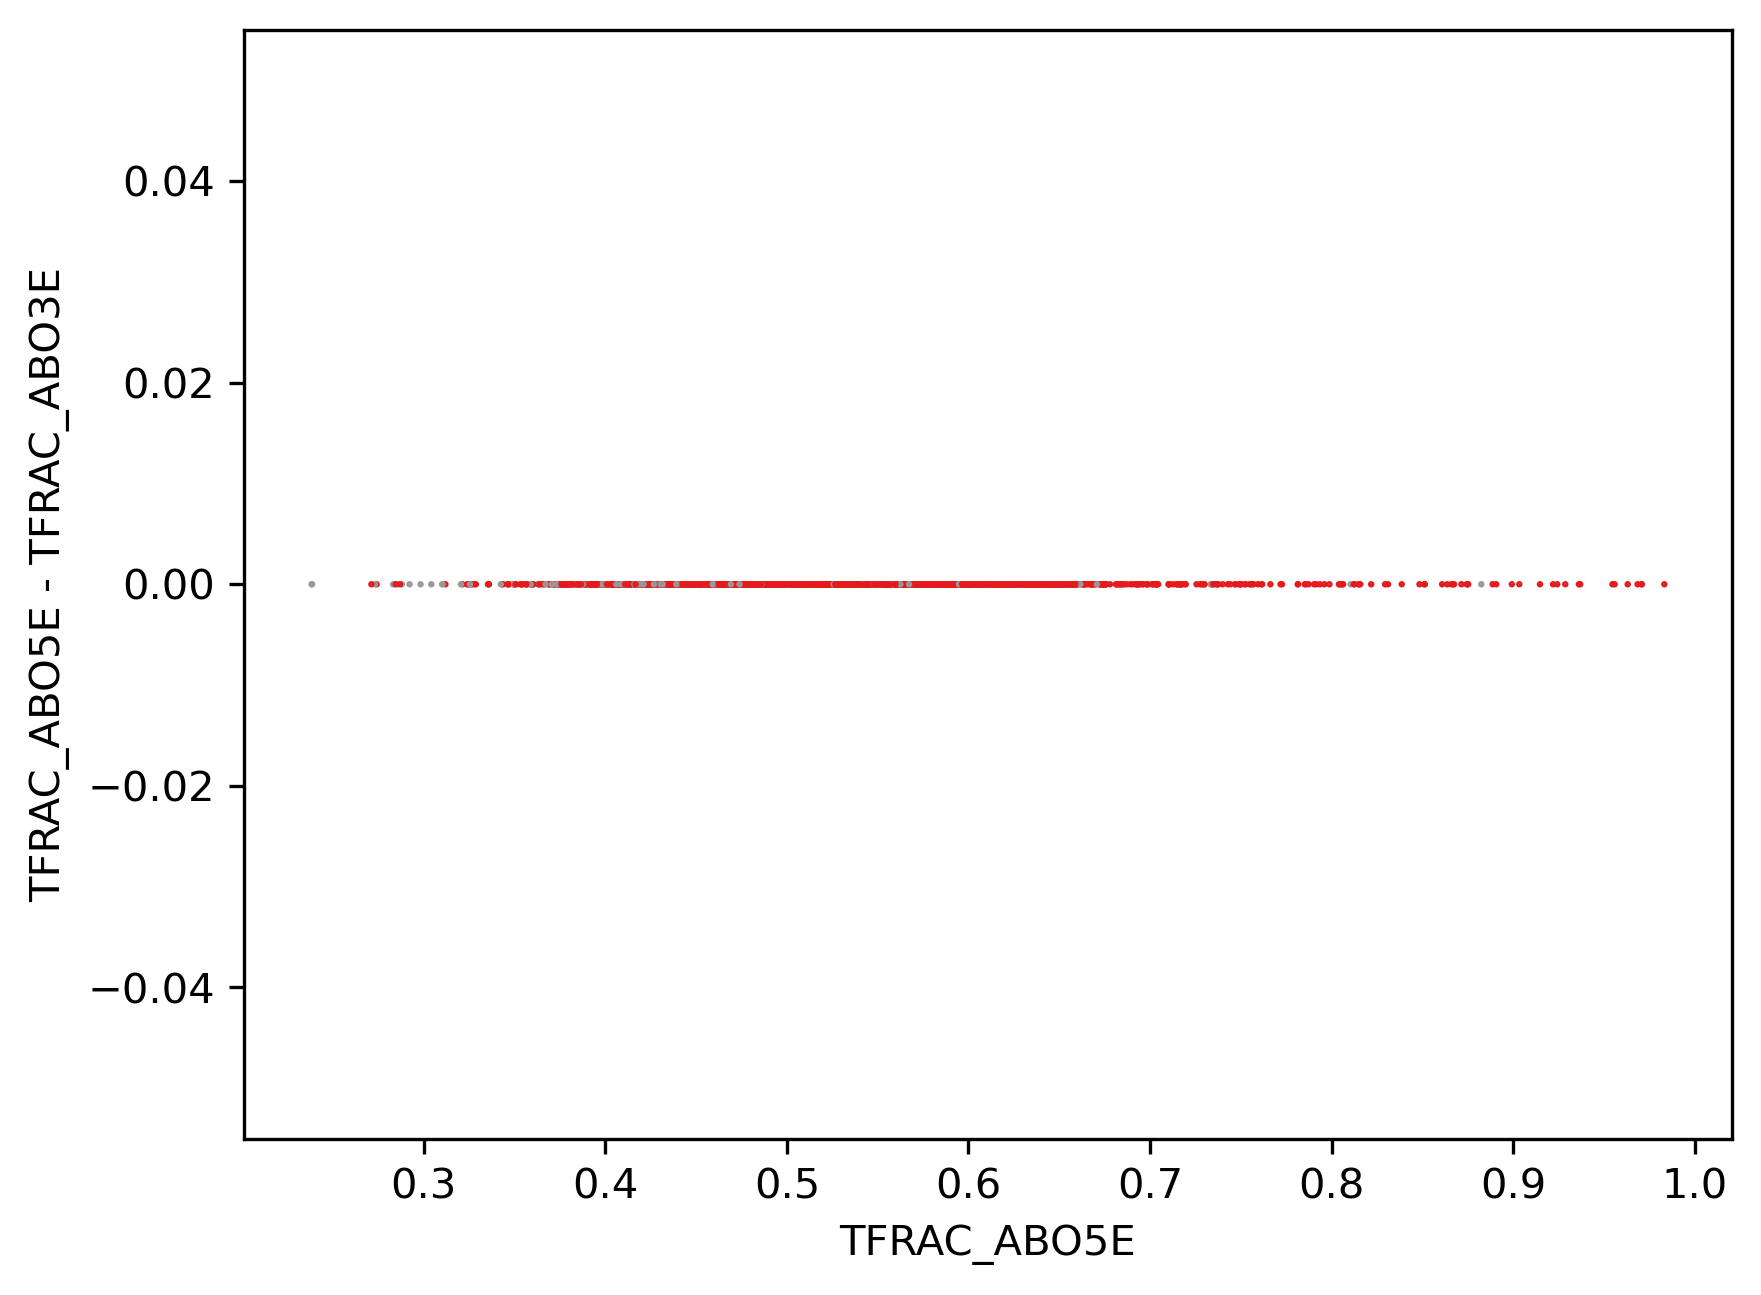

11084

In [132]:
plt.scatter(X_train['TFRAC_ABO5E'], X_train['TFRAC_ABO5E']-X_train['TFRAC_ABO3E'], c=y_train, s=0.3, cmap = 'Set1')
#plt.xlim([-10,10])
#plt.ylim([-1,30])
plt.xlabel("TFRAC_ABO5E")
plt.ylabel('TFRAC_ABO5E - TFRAC_ABO3E')
plt.show()

len(abs((data['TFRAC_ABO5E']-data['TFRAC_ABO3E']))) #sono uguali!!!

The two most important variables in the model-independent XGBoost model are identical...

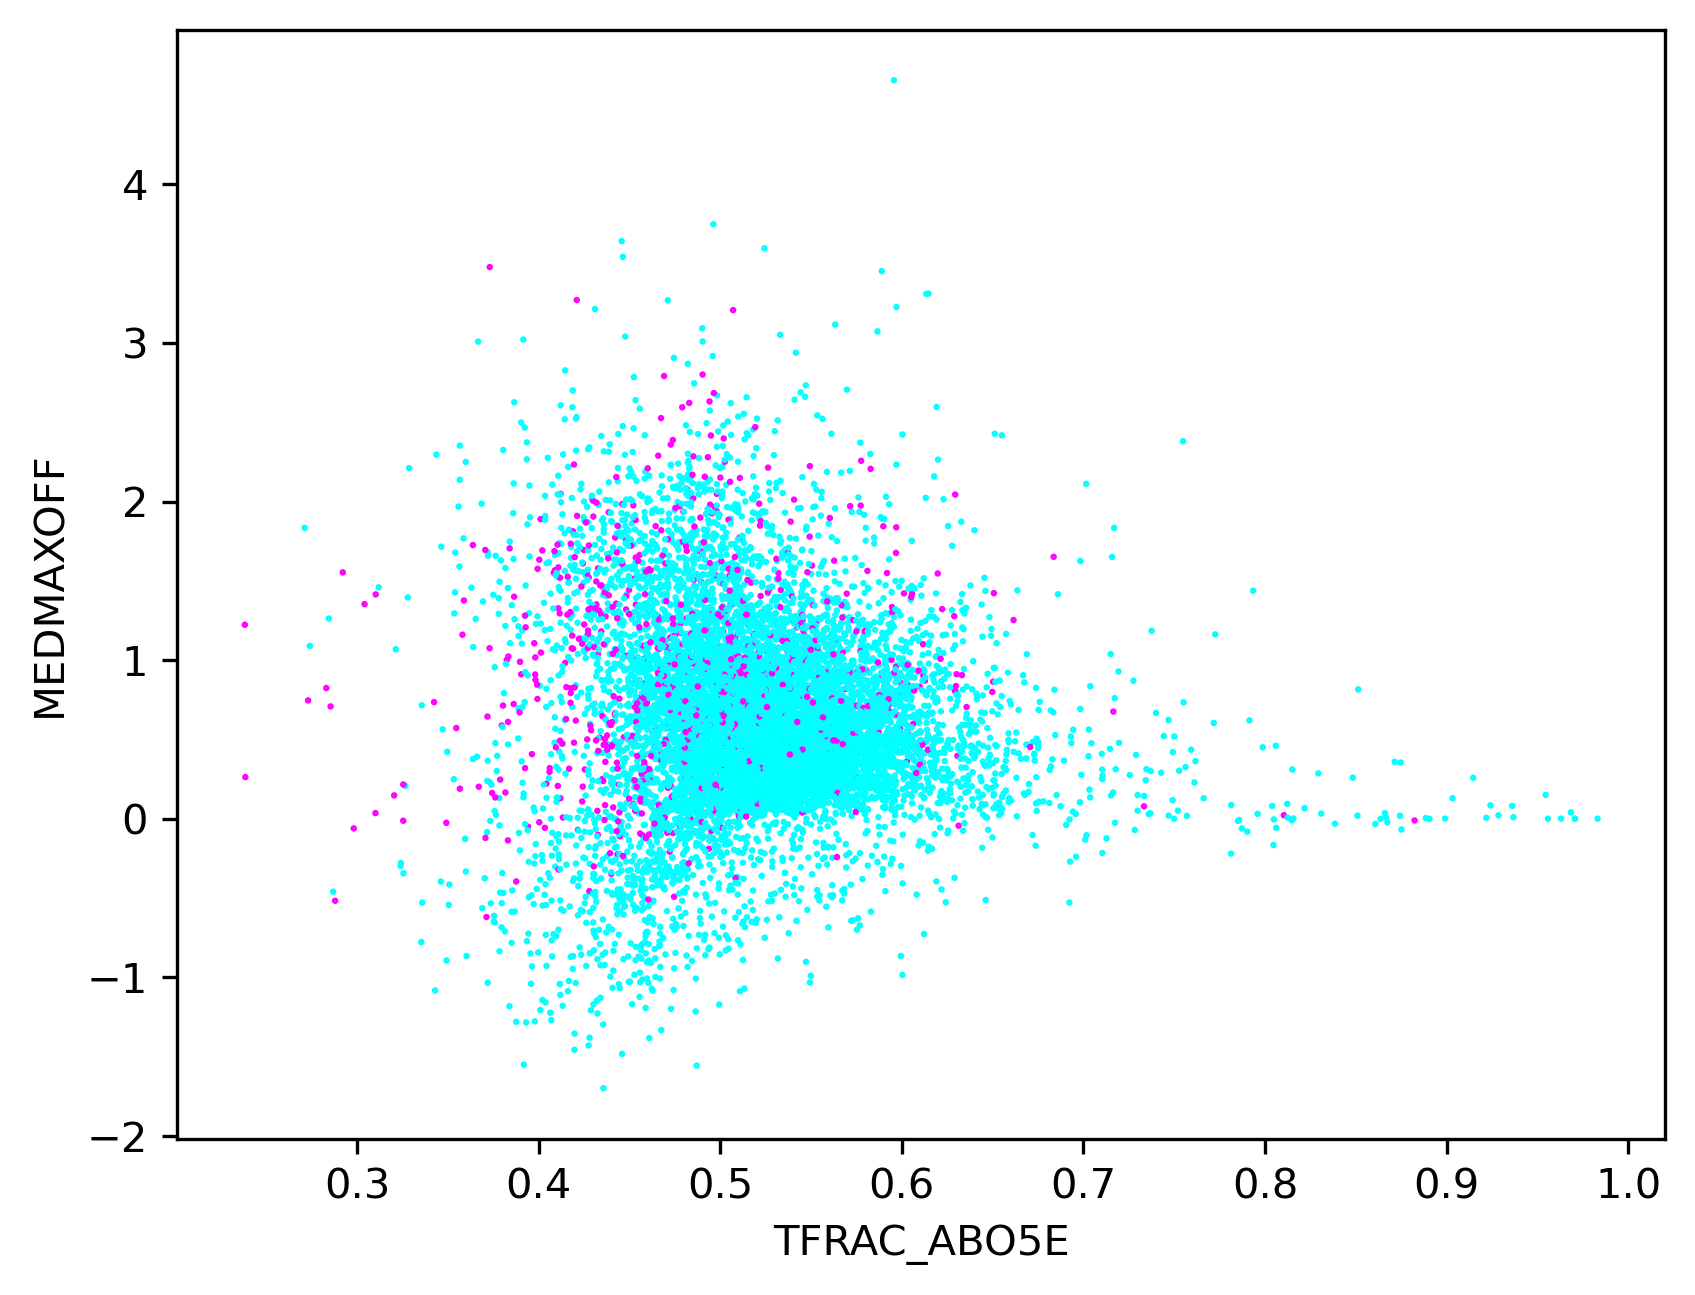

In [120]:
plt.scatter(X_train['TFRAC_ABO5E'], np.log10(X_train['MEDMAXOFF']), c=y_train, s=0.3, cmap='cool')
#plt.xlim([-10,10])
#plt.ylim([-1,30])
plt.xlabel("TFRAC_ABO5E")
plt.ylabel("MEDMAXOFF")
plt.show()

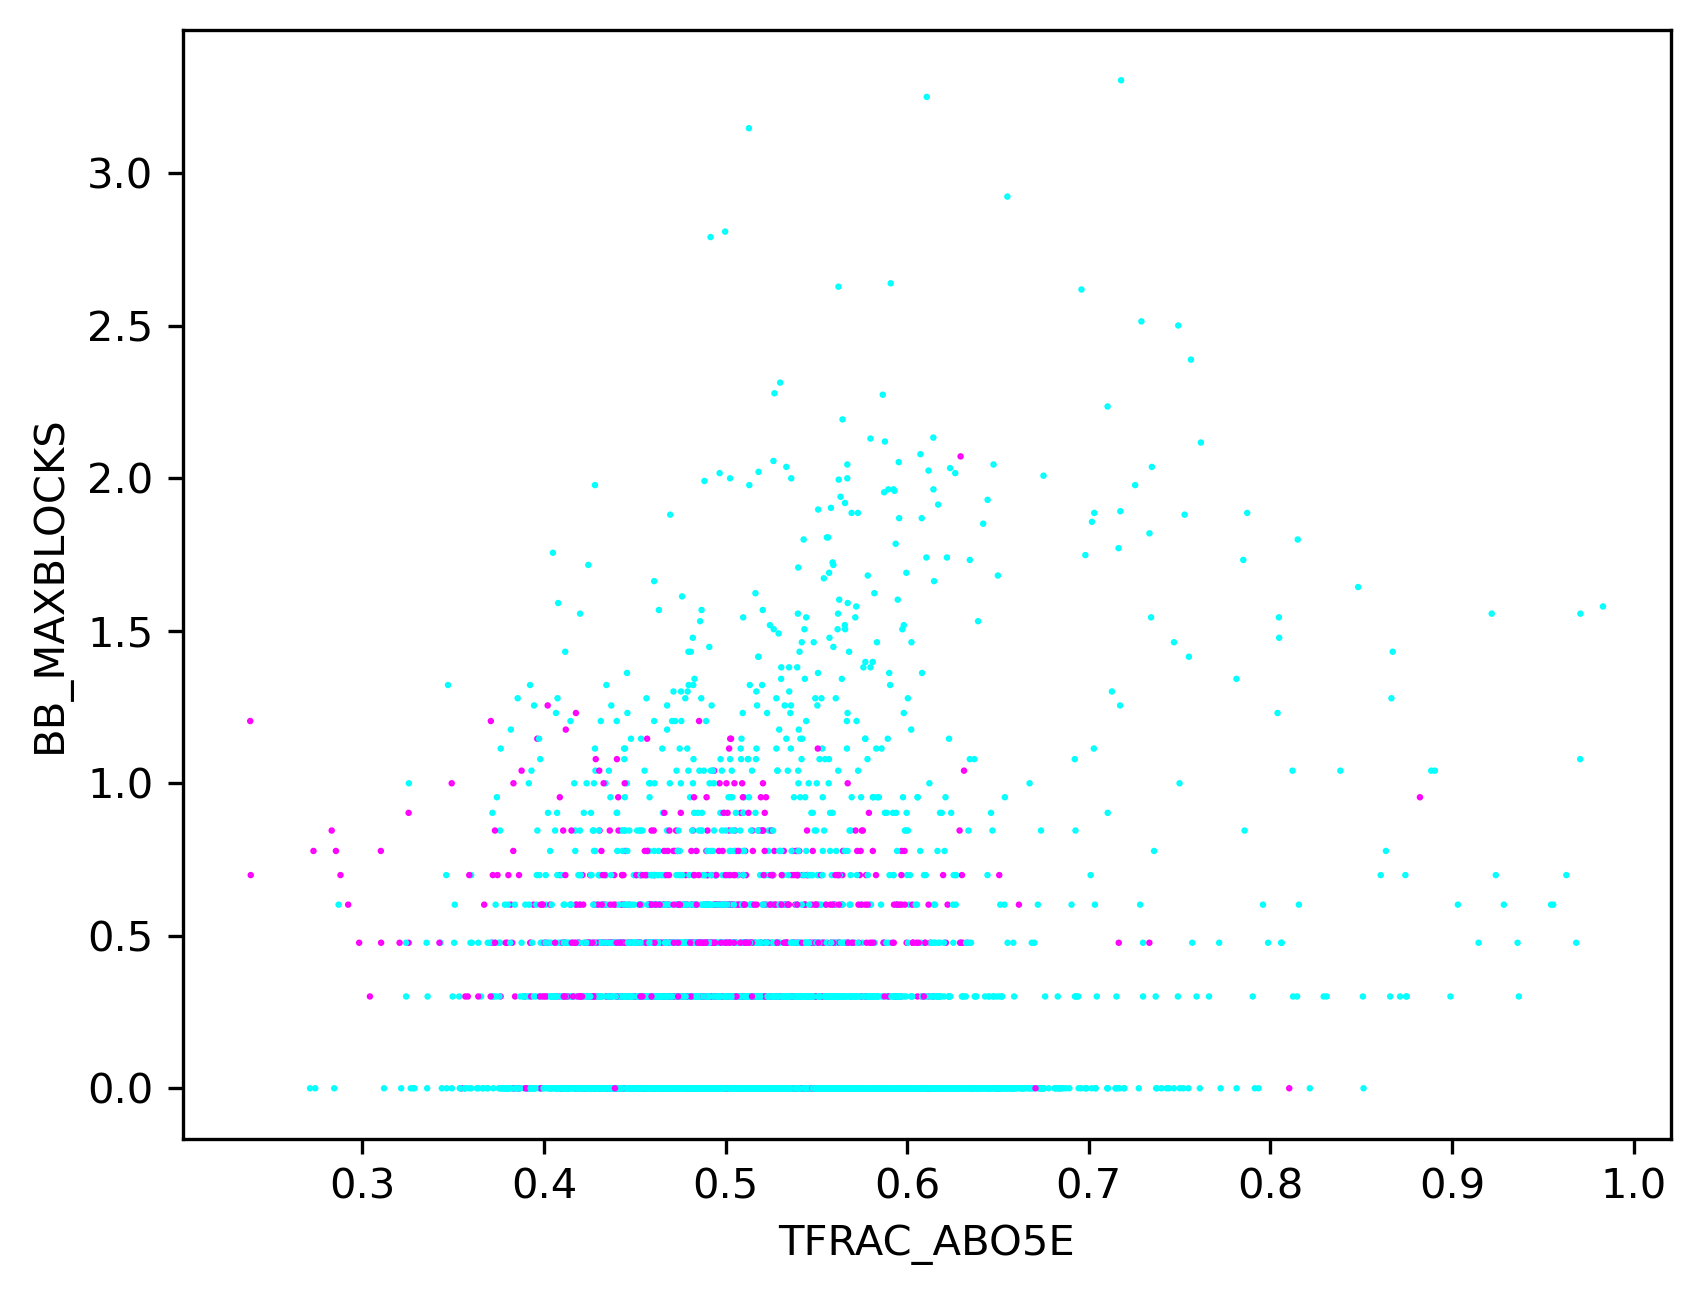

In [124]:
plt.scatter(X_train['TFRAC_ABO5E'], np.log10(X_train['BB_MAXBLOCKS']), c=y_train, s=0.3, cmap='cool')
#plt.xlim([-10,10])
#plt.ylim([-1,30])
plt.xlabel("TFRAC_ABO5E")
plt.ylabel("BB_MAXBLOCKS")
plt.show()

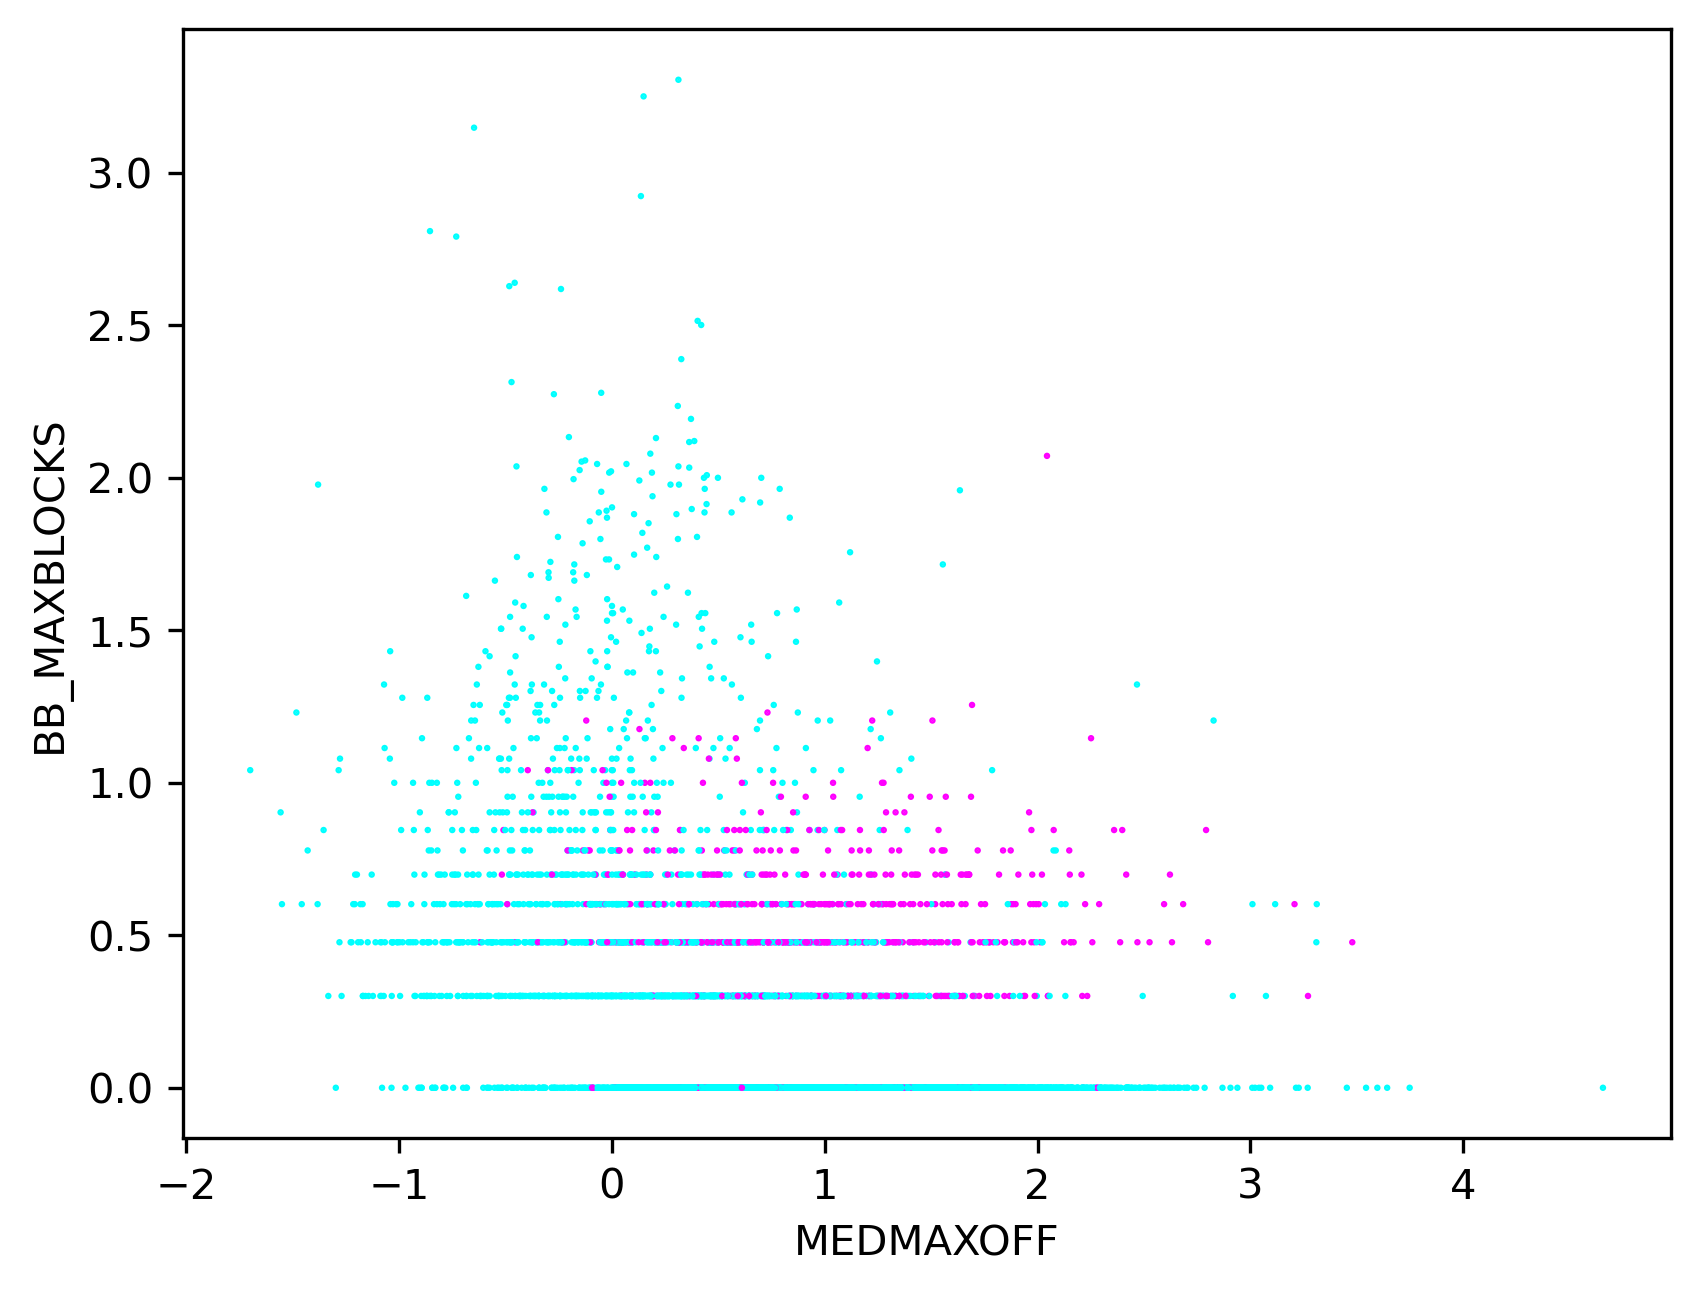

In [125]:
plt.scatter(np.log10(X_train['MEDMAXOFF']), np.log10(X_train['BB_MAXBLOCKS']), c=y_train, s=0.3, cmap='cool')
#plt.xlim([-10,10])
#plt.ylim([-1,30])
plt.xlabel("MEDMAXOFF")
plt.ylabel("BB_MAXBLOCKS")
plt.show()

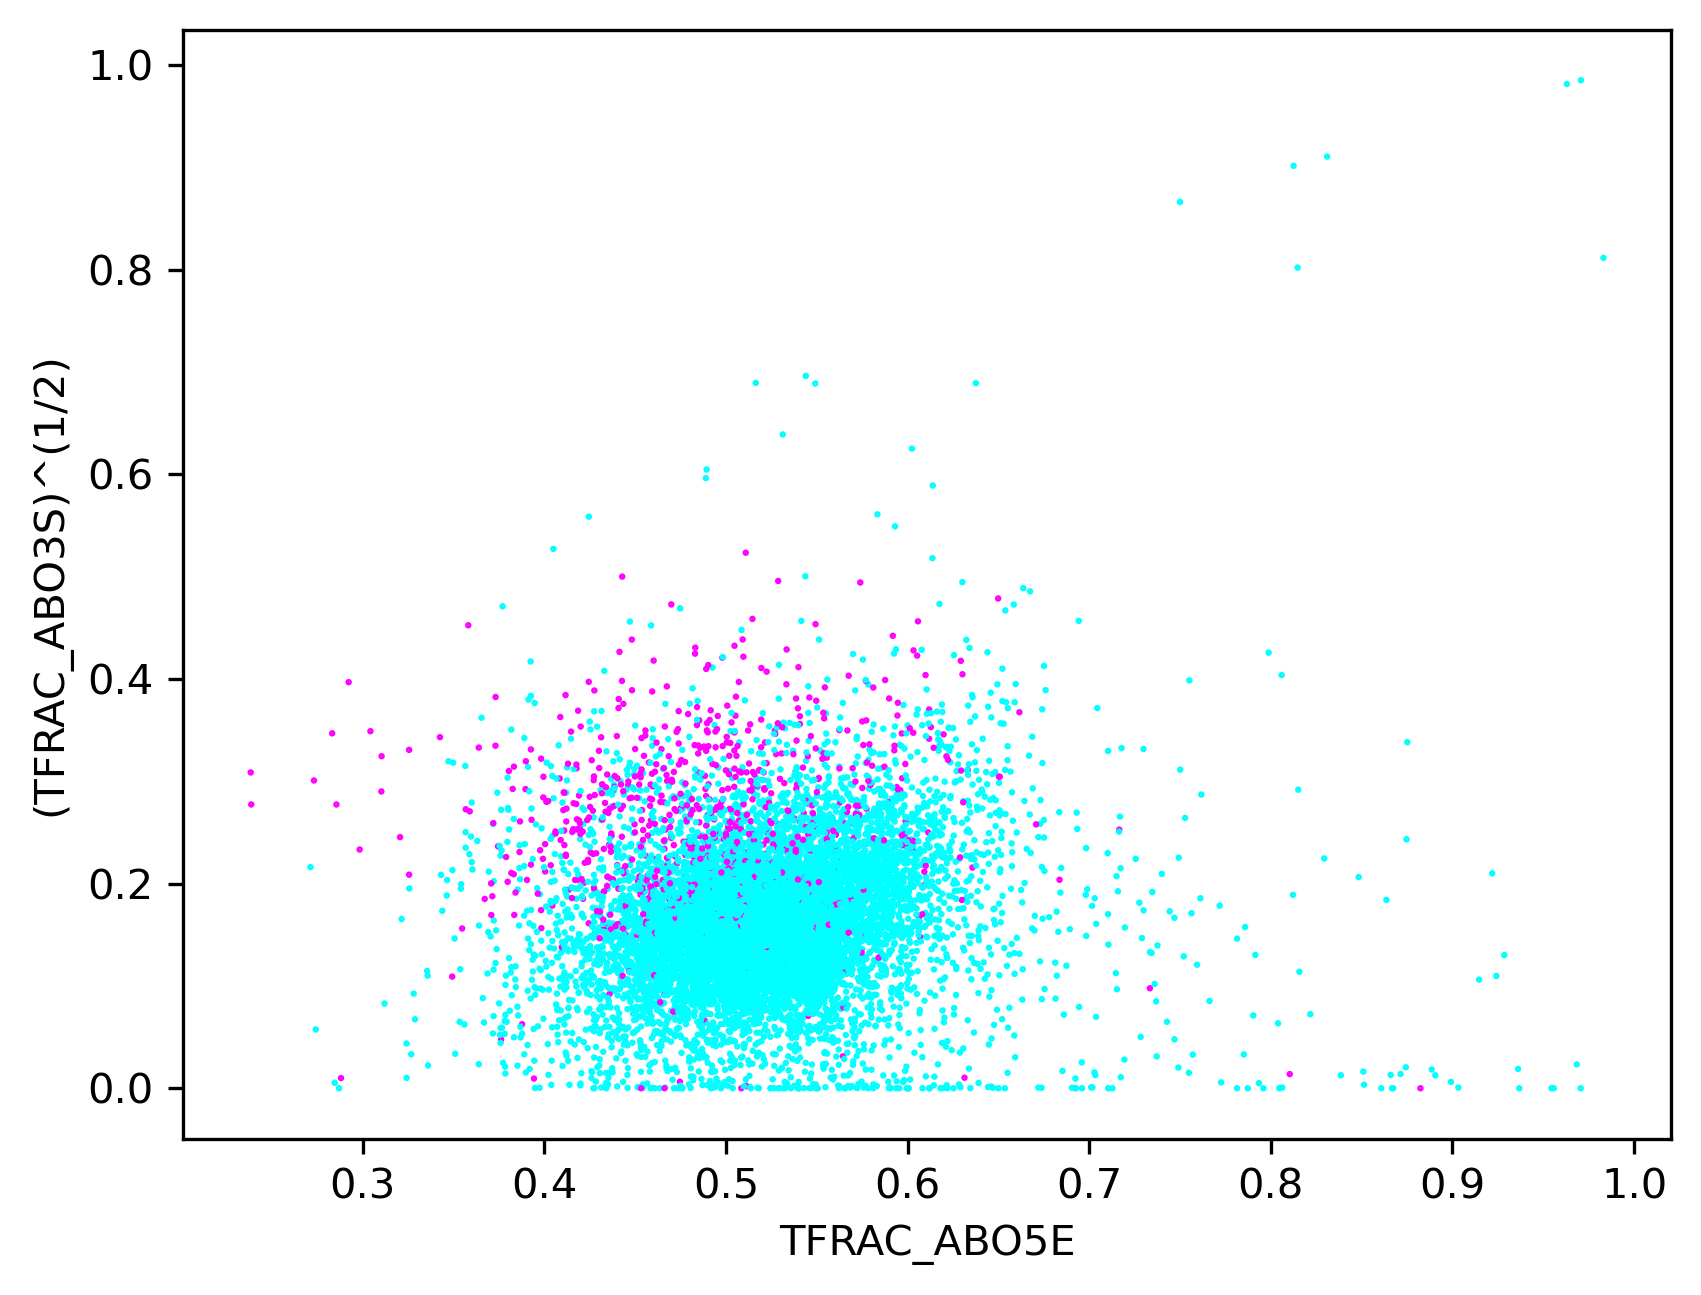

In [130]:
plt.scatter(X_train['TFRAC_ABO5E'], np.sqrt(X_train['TFRAC_ABO3S']), c=y_train, s=0.3, cmap='cool')
#plt.xlim([-10,10])
#plt.ylim([-1,30])
plt.xlabel("TFRAC_ABO5E")
plt.ylabel("(TFRAC_ABO3S)^(1/2)")
plt.show()
